
## extra step 생성

여태까지 Lightning moudle 을 상속받아 다음을 재구성하여 모델을 생성해보았다

- \_\_init\_\_() : 신경망을 구성하는데 사용 (layer 정의)
- forward() : 실제로 신경망에 x 가 들어갔을 때 나오는 y 를 정의 -> 실제로 call 은 forward를 부르는게 아니라 오브젝트를 call 해야함 (나중에 hook등이 동작하게 하기 위해서)
- traning_step : 데이터를 넣었을 때, loss 를 계산하는 방법을 정의 (따라서 traning step 내부에는 당연히 forward 가 포함된 model() call이 있어야 한다) 하고 loss 를 리턴한다.
- validation_step : validation 방법을 정의한다. 별도의 return 은 없어도 된다. (없어도 모델은 돌아감)
- test_step : test 방법을 정의한다. 별도의 return 은 없어도 된다.
  

이를 활용한 기본 모델의 뼈대는 아래와 같다

In [1]:
## 1~5 장까지 실습한 내용
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(28*28, 32)
        self.dense2 = nn.Linear(28*28, 32)
        self.dense2_2= nn.Linear(32, 16)
        self.dense3 = nn.Linear(32+16, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x1 = self.dense1(x)
        x1 = self.relu(x1)

        x2_1 = self.dense2(x)
        x2_1 = self.relu(x2_1)
        x2_2 = self.dense2_2(x2_1)
        x2_2 = self.relu(x2_2)

        x = torch.cat([x1, x2_2], dim=1)
        x = self.dense3(x)

        return(x)
        


def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True) ## 한 번 인터넷으로 가져온걸 매번 가져올 필요가 없기 때문에 가져올때 download True 로 하면 다음 부터는 다운로드 된 데이터를 사용한다.
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return (trainDataLoader,valDataLoader)

trainDataLoader,valDataLoader = dataLoader()

Pylighting 모듈을 상속 받아 뼈대를 만들고 기초적인 신경망(layers)와 이들을 연결해주는 forward를 정의해주었다. 또한 데이터 학습을 위해 데이터 로더를 셋팅해준다.

이제 이 뼈대에 필수적인 Train / Valid / Test 에 대해 정의한다. 이 셋은 거의 형태가 비슷하기 때문에 많은 부분이 겹치는데, Train 같은 경우에는 그 결과값이 loss로 사용되기 때문에 return 이 필요한 반면, valid, test 의 경우에는 별도 loss 를 리턴 할 필요는 없다. (로그에 기록만 하면 됨)

In [2]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y, task="multiclass",num_classes=10)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y, task="multiclass",num_classes=10)
        metrics={'test_loss': loss, 'test_acc':acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
#summary(model, input_size=(8, 1, 28, 28))

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 51.3 K
------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


위 모델에서 MSE는 사실 필요가 없다. 왜냐하면 위 문제는 Classification(분류) 이지, Regression (회귀) 가 아니기 때문이다. 즉 Argmax 로 뽑힌 값이 7 이고, 실제 값이 4라면, MSE 는 (7-4)^2 이 된다. 물론 MSE를 써도 Loss는 얼렁뚱땅 정의가 되긴 한다. (어쨋든 정답이면 0이니까.) 즉 학습이 제대로 된다면 Accuracy가 높아짐에 따라 MSE도 낮아지긴 한다. 하지만 원래 제대로된 Loss 는 Cross Entropy 값이긴 하며, 여기서는 그저 참고로 (작동한다는 걸 보여주기 위해) MSE도 같이 출력하였다.

또한 이 모델에서는 validation step 과 test step 이 모두 정의가 되었기 때문에 아래와 같이 valdiate 나 test 메쏘드를 사용가능하다

In [3]:
trainer.validate(model, valDataLoader)

/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.953000009059906     │
│         val_loss          │    0.16042207181453705    │
│          val_mse          │    0.9003999829292297     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.16042207181453705,
  'val_acc': 0.953000009059906,
  'val_mse': 0.9003999829292297}]

In [4]:
trainer.test(model, valDataLoader)

/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.953000009059906     │
│         test_loss         │    0.16042207181453705    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16042207181453705, 'test_acc': 0.953000009059906}]

참고로 여기서는 데이터를 단지 train / test 만으로 나눴기 때문에 validation step과 test step에 둘다 validation데이터를 넣었고, 그래서 두 step에서 같은 결과가 나왔다. (실제로 코드는 valid step과 test step을 돌았겠지만, 데이터가 같아서 같은 결과 나옴)

또한 별도의 forward() 를 이용하여 학습된 모델을 실행하는 별도의 process 를 생성할 수 도 있다.

In [5]:
class altModel(MyModel):

    def predict_step(self, x, batch_idx):
        y_pred = self(x) ## < forward 에 x를 넣어서 나온 결과 ==> logit 상태임
        y_pb = nn.Softmax(y_pred) ## logit 을 Softmax 취해서 확률로 바꿈
        return y_pb
        

예를들어 Valid나 Test 처럼 최종 결과(정확도등)를 뱉는게 아닌, 들어가는 데이터에 대해 예측한 값을 뱉는 predict 라는 메쏘드를 추가해보자. 이 때 단순히 신경망을 통과시키면 최종 아웃이 10개의 logit value 이기 때문에(마지막 dense3 layer의 out이 10개) 이를 softmax 취해서 확률값으로 변환해줘야 한다.

In [7]:
model = altModel()

즉 이 모델은 위에서 만든 myModel에 메쏘드 하나 추가된 모델이다.

In [8]:

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 51.3 K
---------------------------------
51.3 K    Trainable params
0         Non-trainable params
51.3 K    Total params
0.205     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [10]:
batch = next(iter(valDataLoader)) ##  데이터 로더에서 1개 배치 가져오기 

데이터 로더는 위에서 정의된 바와 같이 한번에 128개씩 데이터를 뱉기 때문에 그 모양을 보면 다음과 같다

In [11]:
print(batch[0].shape) # x 
print(batch[1].shape) # y

torch.Size([128, 1, 28, 28])
torch.Size([128])


배치사이즈가 128개씩 이므로 이중에서 가장 첫번째 x 만 보면

In [15]:
batch[0][0].shape

torch.Size([28, 28])

여기서 1개짜리 차원은 필요가 없기 때문에, tensor의 squeeze 를 사용해서 28*28 이미지로 변환시킬 수 있다.

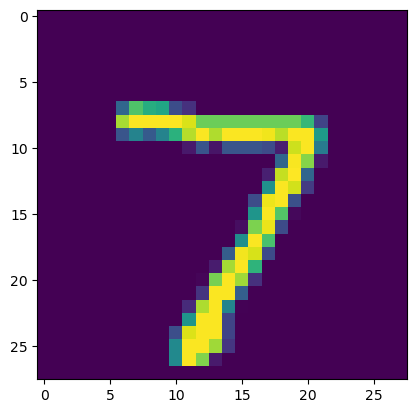

In [10]:
plt.imshow(batch[0][0].squeeze())

위와 같은 글씨임을 알 수 있다. 이걸 실제 모델에 넣어서 forward 시켜보면 

In [16]:
y_logit = model(batch[0][0])

10개의 value가 나온다. 이 값은 최종 dense3를 거친 값으로 logit값이라고 할 수 있다.

In [19]:
print(y_logit.shape)
y_logit[0]

torch.Size([1, 10])


tensor([ -1.4589,  -8.5939,   1.0140,   1.8978,  -7.6713,  -2.4596, -12.8427,
          8.0744,  -2.7505,   0.3389], grad_fn=<SelectBackward0>)

위와 같은 logit 값을 볼 수 있는데, 여기에 softmax 를 취해서 변화하는게 바로 각 class 에 해당하는 probability 이므로 이걸 정의한게 위의 predict 매쏘드이다.

또한  model 에 한번에 batch 를 다 넣으면 넣으면 batch 에 해당하는 갯수 만큼의 logit 묶음 값을 얻을 수 있다. 

In [22]:
y_predcit_with_logit = model(batch[0])

하지만 보통 대부분의 경우 우리가 관심이 있는 값들은 logit 이 아니라 이걸 확률로 변환한 prob 값인데, 우리가 predict_step 에 대해 정의를 했기 때문에, 이제 Trainer  에서도 predict를 사용할 수 있다. (model 에서 predict_step 이 정의가 되었기 때문에 활용가능)

In [20]:
y_predict_with_prob = trainer.predict(model, batch[0])

Predicting: |          | 0/? [00:00<?, ?it/s]

단 주의할점이 있는데, predict step 의 결과는 Softmax를 취한 logit 자체이지, 그 값이 아니다. 이해하기 힘들겠지만, 아래 결과를 보면 logit으로 나온 값을 보면 모델을 통과한 뒤에 각 class 에 해당하는 어떤 계산 값들이다. 

In [23]:
print(y_predcit_with_logit[0])
print(y_predict_with_prob[0])


tensor([ -1.4589,  -8.5939,   1.0140,   1.8978,  -7.6713,  -2.4596, -12.8427,
          8.0744,  -2.7505,   0.3389], grad_fn=<SelectBackward0>)
Softmax(
  dim=tensor([[ -1.4589,  -8.5939,   1.0140,   1.8978,  -7.6713,  -2.4596, -12.8427,
             8.0744,  -2.7505,   0.3389]], device='mps:0')
)


근데 위 결과를 보면, y_predict_with_logit 값은 그렇다 쳐도, 왜 y_predict_with_prob 값이 확률이 아니라 (softmax를 취한 후 값이 아니라) logit 값과 같아 보이는지 이상할 수 있다. 


그 이유는 우리가 predict 한 값은 여기(logit)에 Softmax layer를 취해야 한다는걸 알려주지, 그 값을 알려주지는 않는다. (물론 나중에 여기에 argmax 등을 할 때에는 softmax를 취한 값의 argmax가 취해진다. -> 지금은 이해가 안되도 넘어가도록 하자)

즉, logit 값은  -1, -2, -3 이에요. 라면
predict 값은 -1, -2, -3 에 softmax를 취하면 되요. 라고 알려주지, softmax를 취한 결과를 보여주진 않는다. (맨 앞에 Softmax() 라고 쓰여있음에 주목.)

그럼 실제로 추론하는 과정을 대략적으로 이해해보면

In [24]:
batch = next(iter(valDataLoader))  ## 데이터로더로부터 다음의 batch 를 가져온다.

model.eval() ## evaluation mode로 바꾼다. (drop out, batch normalization 등)

y_pred = model(batch[0]) # batch 의 x 가 들어간다. input(128, 1, 28, 28) -> output (128, 10)

print(y_pred.size()) ## tensor with 128 x 10
print(y_pred[0, :])  ## 그 중 첫번째의 logit values, numpy 와 비슷하지만 뒤에 grad 정보가 있기 때문에 바로 그리거나 할 수 는 없음 이를 detach

print("----")
# 주의 np.argmax( y_predict[0, :] ) 불가
print(y_pred[0, :].detach())  ## grad_fn 부분이 사라진다.
print("----")
softmax =  nn.Softmax(dim=0) 
print( softmax( y_pred[0, :].detach()  )) 
print("----")
print(np.argmax(softmax( y_pred[0, :].detach() ))) ## 이중 최대값의 argmax 


torch.Size([128, 10])
tensor([ -1.4589,  -8.5939,   1.0140,   1.8978,  -7.6713,  -2.4596, -12.8427,
          8.0744,  -2.7505,   0.3389], grad_fn=<SliceBackward0>)
----
tensor([ -1.4589,  -8.5939,   1.0140,   1.8978,  -7.6713,  -2.4596, -12.8427,
          8.0744,  -2.7505,   0.3389])
----
tensor([7.2152e-05, 5.7484e-08, 8.5546e-04, 2.0702e-03, 1.4462e-07, 2.6524e-05,
        8.2093e-10, 9.9652e-01, 1.9829e-05, 4.3552e-04])
----
tensor(7)


위와 같이 이루어진다고 보면 된다. 단 여기서 grad 가 포함되어 있는 Tensor는 일반적인 numpy 연산이 안되기 때문에 grad 부분을 때주는 detach를 해주거나 아니면 아래처럼 no_grad 옵션을 줘야한다.  (아래 예제코드의 경우 : 사실 제대로 하면 softmax를 취한 다음에 argmax를 해야하지만 일반적으로 logit 이 최고인 값이 softmax도 최고이기 때문에 확률로 변환된 값이 필요한게 아니라면(그냥 최대값만 보고 싶으면) 여기서 바로 argmax 해도 된다)


In [25]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
## Sets the module in evaluation mode.(Dropout,BN,..)
model.eval()

## disabled gradient calculation.(reduce memory)
with torch.no_grad():             ### w/o grad_fn object ###
    y_predict = model(batch[0])   # model <- image only

## y_predict 는 이제 grad 가 없는 상태임

print(y_predict,'\n')                 # (128,10) tensor, w/o grad_fn
print(y_predict[0,:],'\n')            # (10,)    tensor, w/o grad_fn
print(np.argmax(y_predict[0,:].numpy()),'np') # numpy index
print(np.argmax(y_predict[0,:]),'tensor') # tensor index

tensor([[ -1.4589,  -8.5939,   1.0140,  ...,   8.0744,  -2.7505,   0.3389],
        [  1.2470,   0.3572,   9.6712,  ..., -12.1495,   0.5434, -11.8778],
        [ -5.1120,   5.2415,  -0.1717,  ...,   0.3534,  -1.5062,  -1.8382],
        ...,
        [ -7.2033,  -1.4460,  -0.0136,  ...,  -2.5209,  -1.0098,   4.0318],
        [  4.0259,  -4.7283,   0.4463,  ...,  -1.2074,  -2.2853,  -0.1946],
        [ -1.2763,  -6.5693,  -5.3450,  ...,  -7.7209,   0.5016,  -1.0334]]) 

tensor([ -1.4589,  -8.5939,   1.0140,   1.8978,  -7.6713,  -2.4596, -12.8427,
          8.0744,  -2.7505,   0.3389]) 

7 np
tensor(7) tensor


In [26]:
print(np.argmax(model(batch[0]).detach(),axis=1).numpy())  # 예측한 숫자

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 0 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 4 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5]


In [27]:
print(batch[1]) # 정답 Label

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])


In [28]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))

In [29]:
# train_loader안의 실제값 한개 뽑아서 확인 
dataiter = iter(valDataLoader)

dataiter는  valDataLoader에서의 한개 iterator 받은 상태로 내부 함수인 \_\_next\_\_ 를 통해서 다음 배치를 받을 수 있다. (next(iter)와 같음)

In [41]:
images, labels = dataiter.__next__()
images.size()

torch.Size([128, 1, 28, 28])

In [42]:
labels

tensor([2, 2, 6, 3, 2, 6, 5, 4, 8, 9, 7, 1, 3, 0, 3, 8, 3, 1, 9, 3, 4, 4, 6, 4,
        2, 1, 8, 2, 5, 4, 8, 8, 4, 0, 0, 2, 3, 2, 7, 7, 0, 8, 7, 4, 4, 7, 9, 6,
        9, 0, 9, 8, 0, 4, 6, 0, 6, 3, 5, 4, 8, 3, 3, 9, 3, 3, 3, 7, 8, 0, 8, 2,
        1, 7, 0, 6, 5, 4, 3, 8, 0, 9, 6, 3, 8, 0, 9, 9, 6, 8, 6, 8, 5, 7, 8, 6,
        0, 2, 4, 0, 2, 2, 3, 1, 9, 7, 5, 1, 0, 8, 4, 6, 2, 6, 7, 9, 3, 2, 9, 8,
        2, 2, 9, 2, 7, 3, 5, 9])

In [43]:
y_pred_label = np.argmax(model(images).detach(),axis=1).numpy()
y_real_label = labels

실제 라벨과 예측한 라벨의 갯수를 보기 위해 (즉 accuracy 확인을 위해) list 에 같은 경우와 다른 경우를 각각 저장하면

In [65]:
correct_idx_list = []
incorrect_idx_list = [] 
for idx in range(images.size(0)):
    if y_pred_label[idx] == y_real_label[idx] :
        correct_idx_list.append(idx)
    else: 
        incorrect_idx_list.append(idx)

In [66]:
print(len(correct_idx_list))
print(len(incorrect_idx_list))

117
11


약 91%로 summary 결과와 비슷하게 나온다. 틀린 결과를 확인해보면

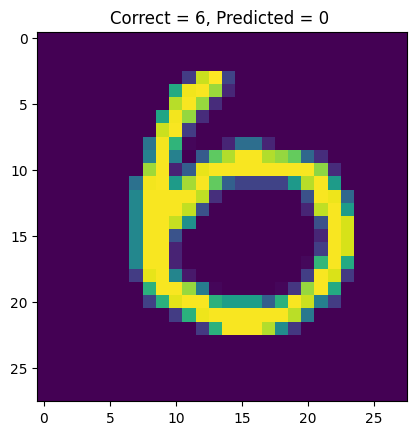

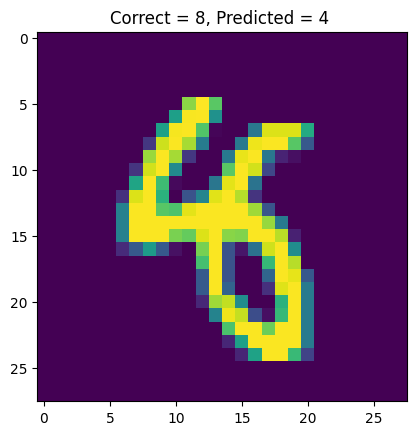

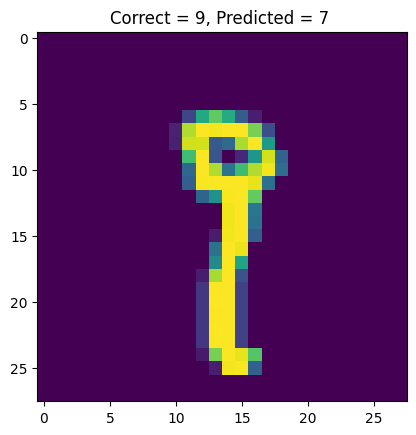

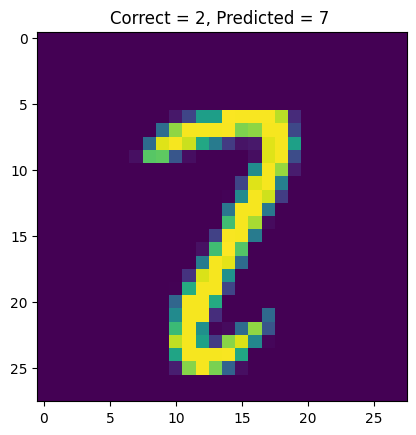

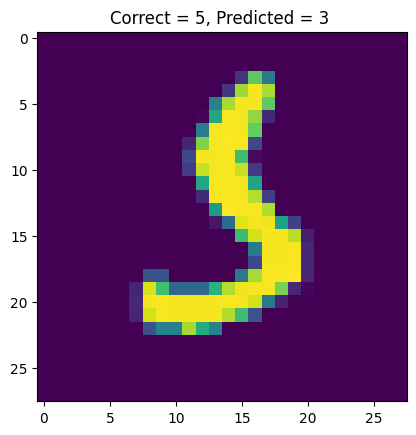

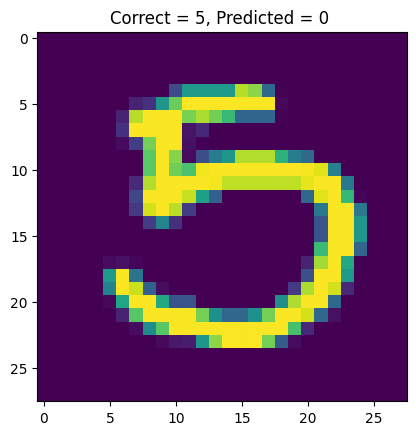

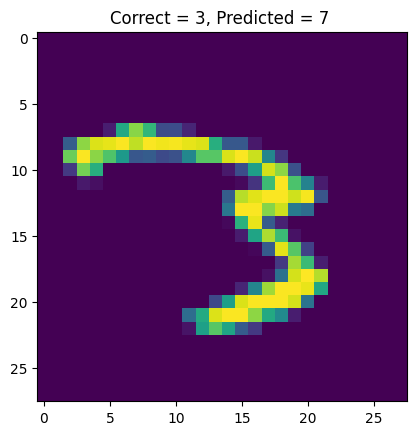

In [207]:
for i in incorrect_idx_list:
    plt.imshow(images[i].squeeze())
    plt.title(f"Correct = {y_real_label[i]}, Predicted = {y_pred_label[i]} ")
    plt.show()